# Hacking the TSB Model for Intermediate Time Series to Accommodate for Availability Constraints

In many demand forecasting problems, we are faced with the challenge of predicting the demand for a product or service with very sparse data. This is specially true in retail where we have many products that are only sold occasionally. This sparsity can come from many sources as greatly described in the (recommended!) blog post ["Why zeroes happen"](https://openforecast.org/2024/11/18/why-zeroes-happen/) by [Ivan Svetunkov](https://openforecast.org/). One one hand, the sparsity can simply come from the lack of demand for the product. On the other hand, the sparsity can also come from the lack of availability of the product. For example, a product might be only available for purchase during certain times of the year, or only in certain geographical locations. There could be other reasons as well. In this notebook we experiment with an extension on a classical TSB time-series model for intermediate time series to accommodate for availability constraints.

For an introduction to the TSB model from a probabilistic forecasting perspective, please see the first blog post ["TSB Method for Intermittent Time Series Forecasting in NumPyro"](https://juanitorduz.github.io/tsb_numpyro/). We have done previous experiments hacking this model in the past (see[Zero-Inflated TSB Model](https://juanitorduz.github.io/zi_tsb_numpyro/)). This time we experiment more with adding additional features rather than changing the model structure. We also show this how to do this at scale (here we run a simulation with 1K series and 60 timesteps). We truly believe exploring these kind of extension are key for real applications.This experiment was motivated by the work of [Ivan Svetunkov](https://openforecast.org/) on ["Intermittent State Space Models"](https://openforecast.org/adam/ADAMIntermittent.html).

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import xarray as xr
from jax import random
from jaxtyping import Array, Float32, Int32, UInt32
from numpyro.contrib.control_flow import scan
from numpyro.handlers import condition
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from pydantic import BaseModel, ConfigDict
from tqdm.notebook import tqdm
from xarray import DataArray  # noqa: F401

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

We generate a synthetic data set where we generate sparse time series data through a Poisson process with a small rate parameter (to get some zeroes). Then we generate a binary availability mask that randomly assigns 0s and 1s to the counts through a Bernoulli process. To obtain the observed counts we simply multiply the availability mask by the counts. As in real cases, we have access to both the counts and the availability mask. We do not have access to the raw counts (without the availability mask). To store our data we create a `ModelData` container (have you checked [`jaxtyping`](https://docs.kidger.site/jaxtyping/)? If not, you should!).

In [2]:
class ModelData(BaseModel):
    counts: Float32[Array, "_ n_series"]
    available: Float32[Array, "_ n_series"]
    t: Int32[Array, "_"]  # noqa: F821
    model_config = ConfigDict(arbitrary_types_allowed=True)

We then generate the data with the following function.

In [3]:
def generate_intermittent_counts(
    rng_key: UInt32[Array, "2"],
    n_series: int,
    t_max: int,
    a: float = 1.0,
    p: float = 0.5,
) -> ModelData:
    """Generate intermittent time series data with availability constraints."""
    # Generate Poisson rate parameters from a global Gamma distribution.
    rng_key, rng_subkey = random.split(rng_key)
    lambdas = random.gamma(rng_subkey, a=a, shape=(1, n_series))

    # Generate counts from the Poisson distribution.
    rng_key, rng_subkey = random.split(rng_key)
    counts = random.poisson(rng_subkey, lam=lambdas, shape=(t_max, n_series))
    counts = counts.astype(jnp.float32)

    # Generate availability mask from a Bernoulli distribution.
    rng_key, rng_subkey = random.split(rng_key)
    available = random.bernoulli(rng_subkey, p=p, shape=counts.shape).astype(
        jnp.float32
    )

    # Multiply counts by availability mask to get observed counts.
    counts = available * counts

    # Create time index.
    t = jnp.arange(counts.shape[0])

    return ModelData(counts=counts, available=available, t=t)

Next, we do a simple train-test split for model evaluation.


In [4]:
def train_dest_split(
    model_data: ModelData, t_max_train: int
) -> tuple[ModelData, ModelData]:
    counts_train = model_data.counts[:t_max_train, :]
    counts_test = model_data.counts[t_max_train:, :]

    available_train = model_data.available[:t_max_train, :]
    available_test = model_data.available[t_max_train:, :]

    t_train = jnp.arange(counts_train.shape[0])
    t_test = jnp.arange(
        counts_train.shape[0], counts_train.shape[0] + counts_test.shape[0]
    )

    model_data_train = ModelData(
        counts=counts_train, available=available_train, t=t_train
    )
    model_data_test = ModelData(counts=counts_test, available=available_test, t=t_test)

    return model_data_train, model_data_test

Let's proceed to generate the data.

In [5]:
model_data = generate_intermittent_counts(
    rng_key, n_series=1_000, t_max=60, a=2.5, p=0.5
)

model_data_train, model_data_test = train_dest_split(model_data, t_max_train=50)

series_ids = jnp.arange(model_data.counts.shape[1])

print(f"model_data.counts.shape: {model_data.counts.shape}")
print(f"model_data_train.counts.shape: {model_data_train.counts.shape}")
print(f"model_data_test.counts.shape: {model_data_test.counts.shape}")

model_data.counts.shape: (60, 1000)
model_data_train.counts.shape: (50, 1000)
model_data_test.counts.shape: (10, 1000)


We can visualize a subsample of the training and test data plus the availability mask.

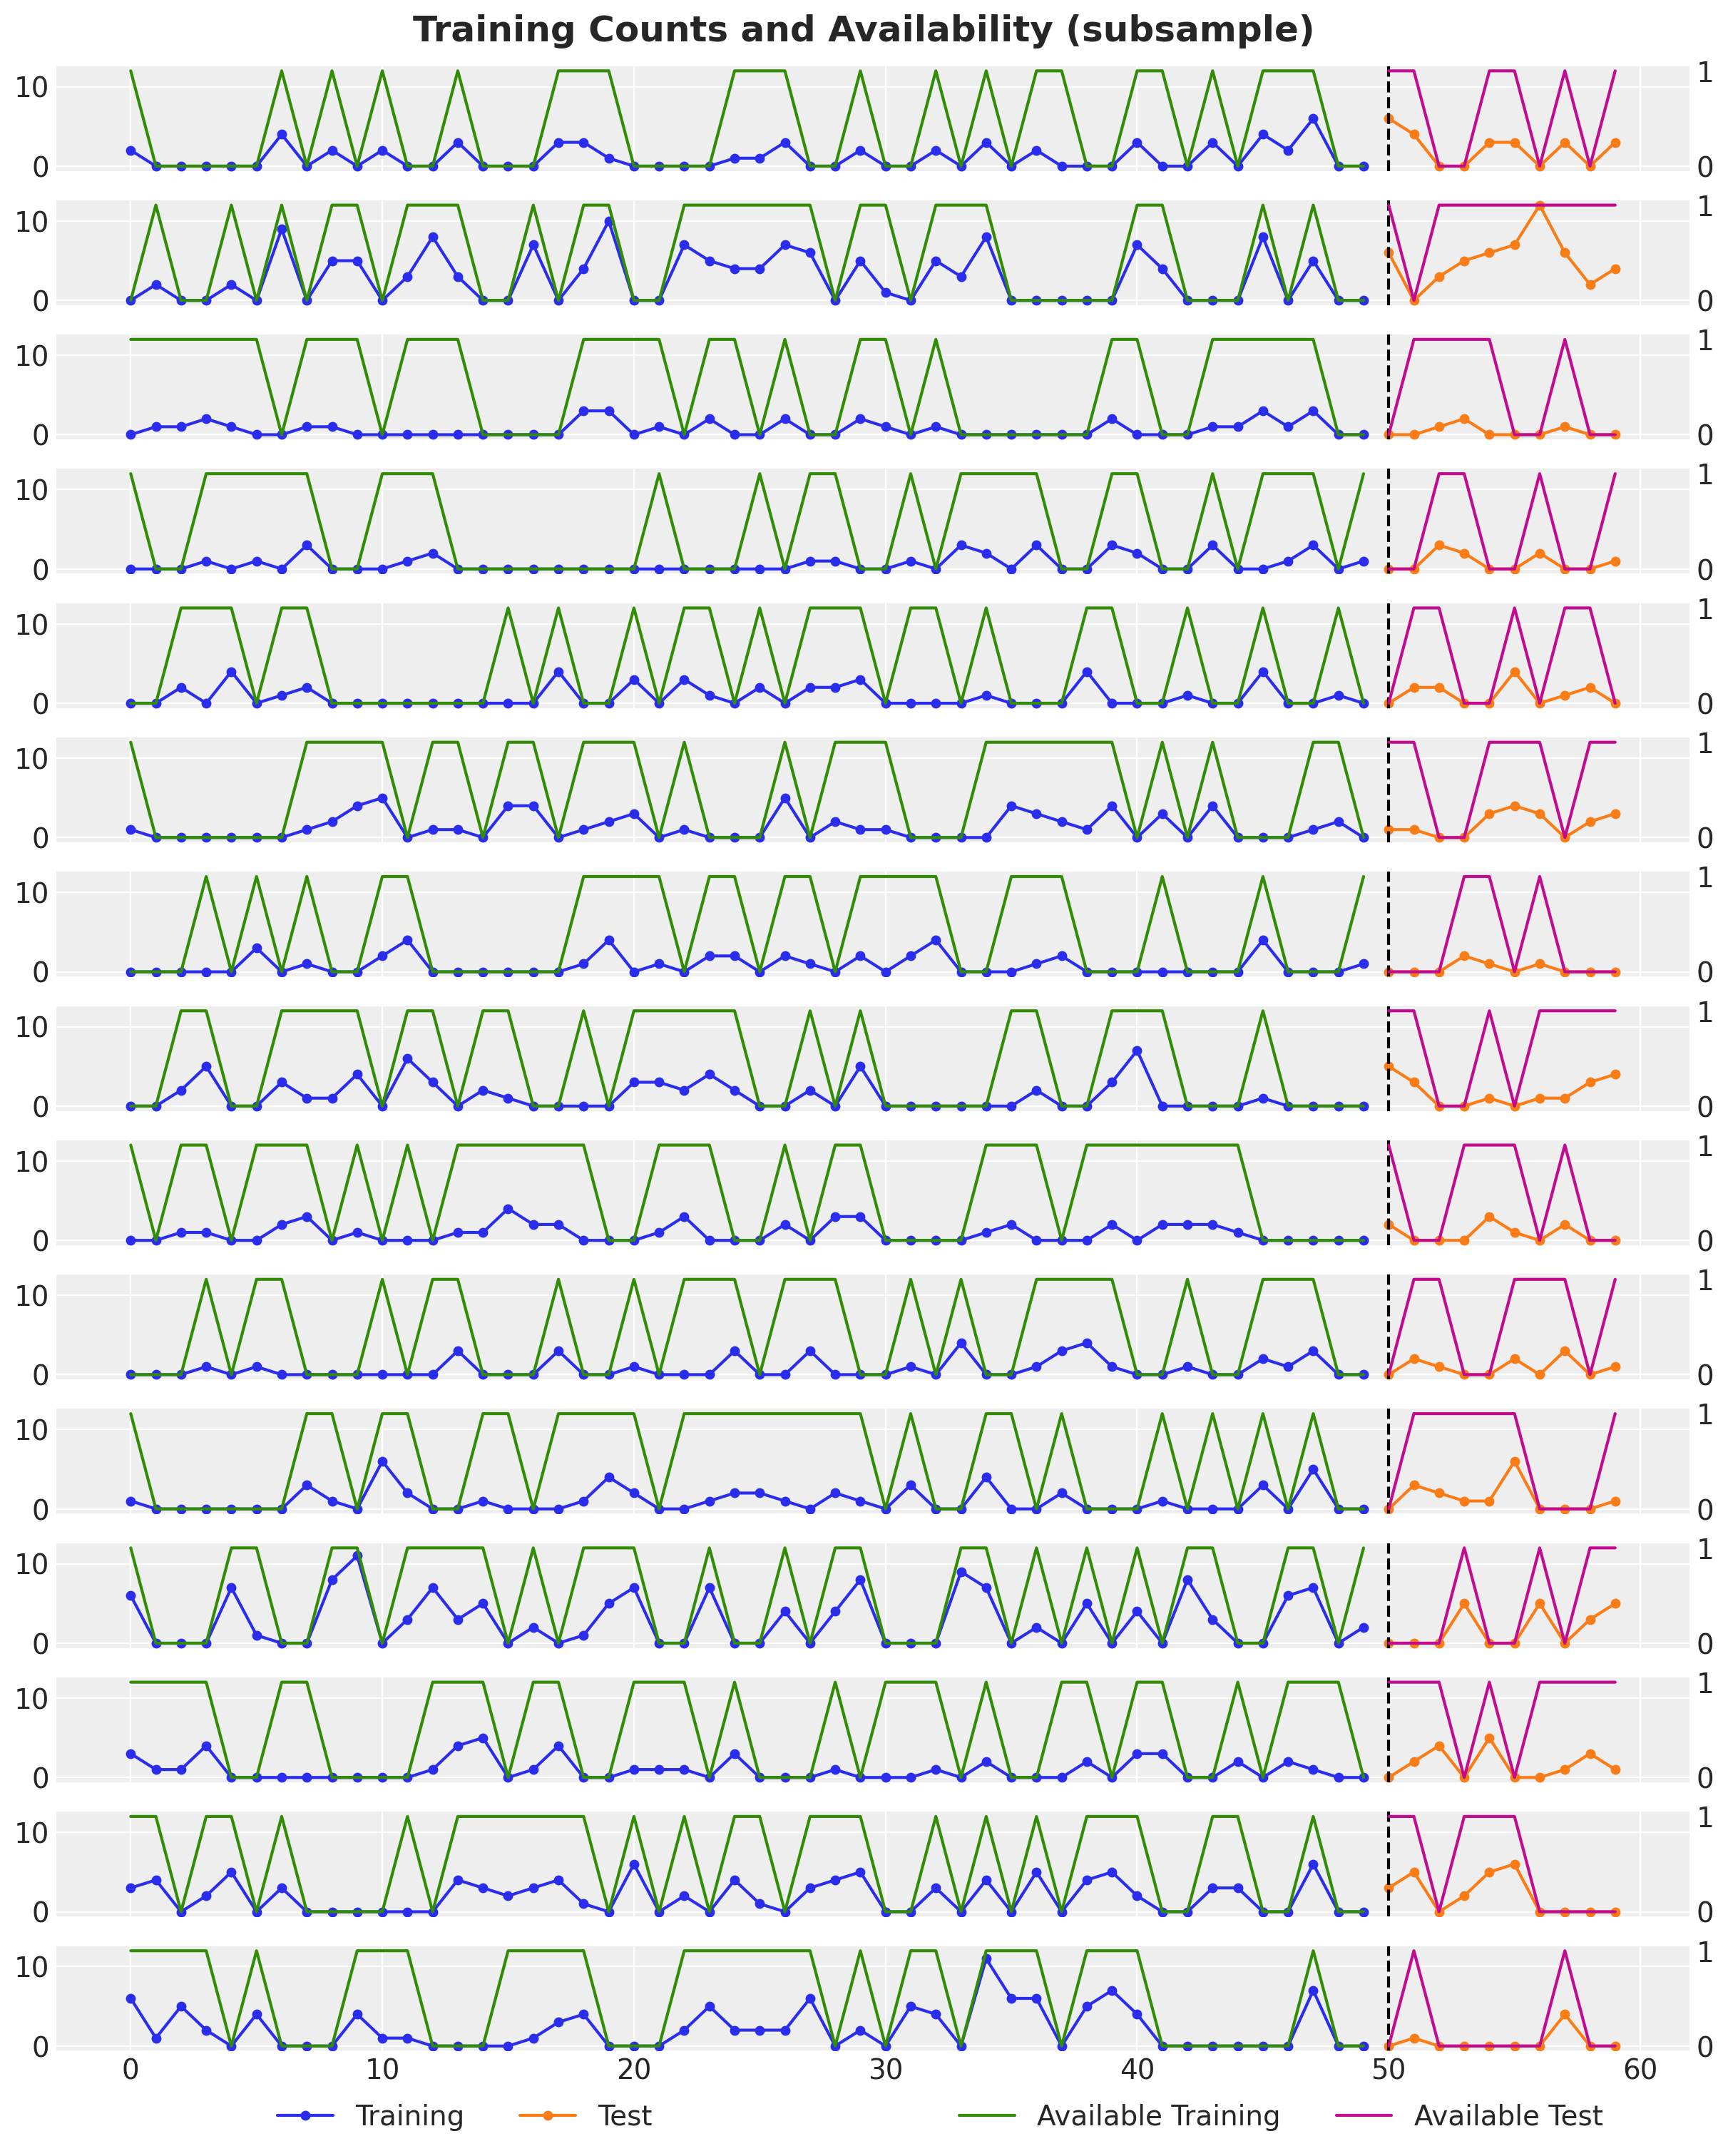

In [6]:
n_series_to_plot = 15

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    ax_i_twin = ax[i].twinx()
    ax[i].plot(
        model_data_train.t,
        model_data_train.counts[:, i],
        marker="o",
        markersize=4,
        color="C0",
        label="Training",
    )
    ax[i].plot(
        model_data_test.t,
        model_data_test.counts[:, i],
        marker="o",
        markersize=4,
        color="C1",
        label="Test",
    )
    ax[i].axvline(x=model_data_train.t.shape[0], color="k", linestyle="--")

    ax_i_twin.plot(
        model_data_train.t,
        model_data_train.available[:, i],
        color="C2",
        label="Available Training",
    )
    ax_i_twin.plot(
        model_data_test.t,
        model_data_test.available[:, i],
        color="C3",
        label="Available Test",
    )
    ax_i_twin.grid(None)

ax[i].legend(loc="lower center", bbox_to_anchor=(0.25, -1), ncol=2)
ax_i_twin.legend(loc="lower center", bbox_to_anchor=(0.75, -1), ncol=2)

fig.suptitle(
    "Training Counts and Availability (subsample)", fontsize=18, fontweight="bold"
);

Let's plot all the training counts to get an idea of the amplitude of the data.

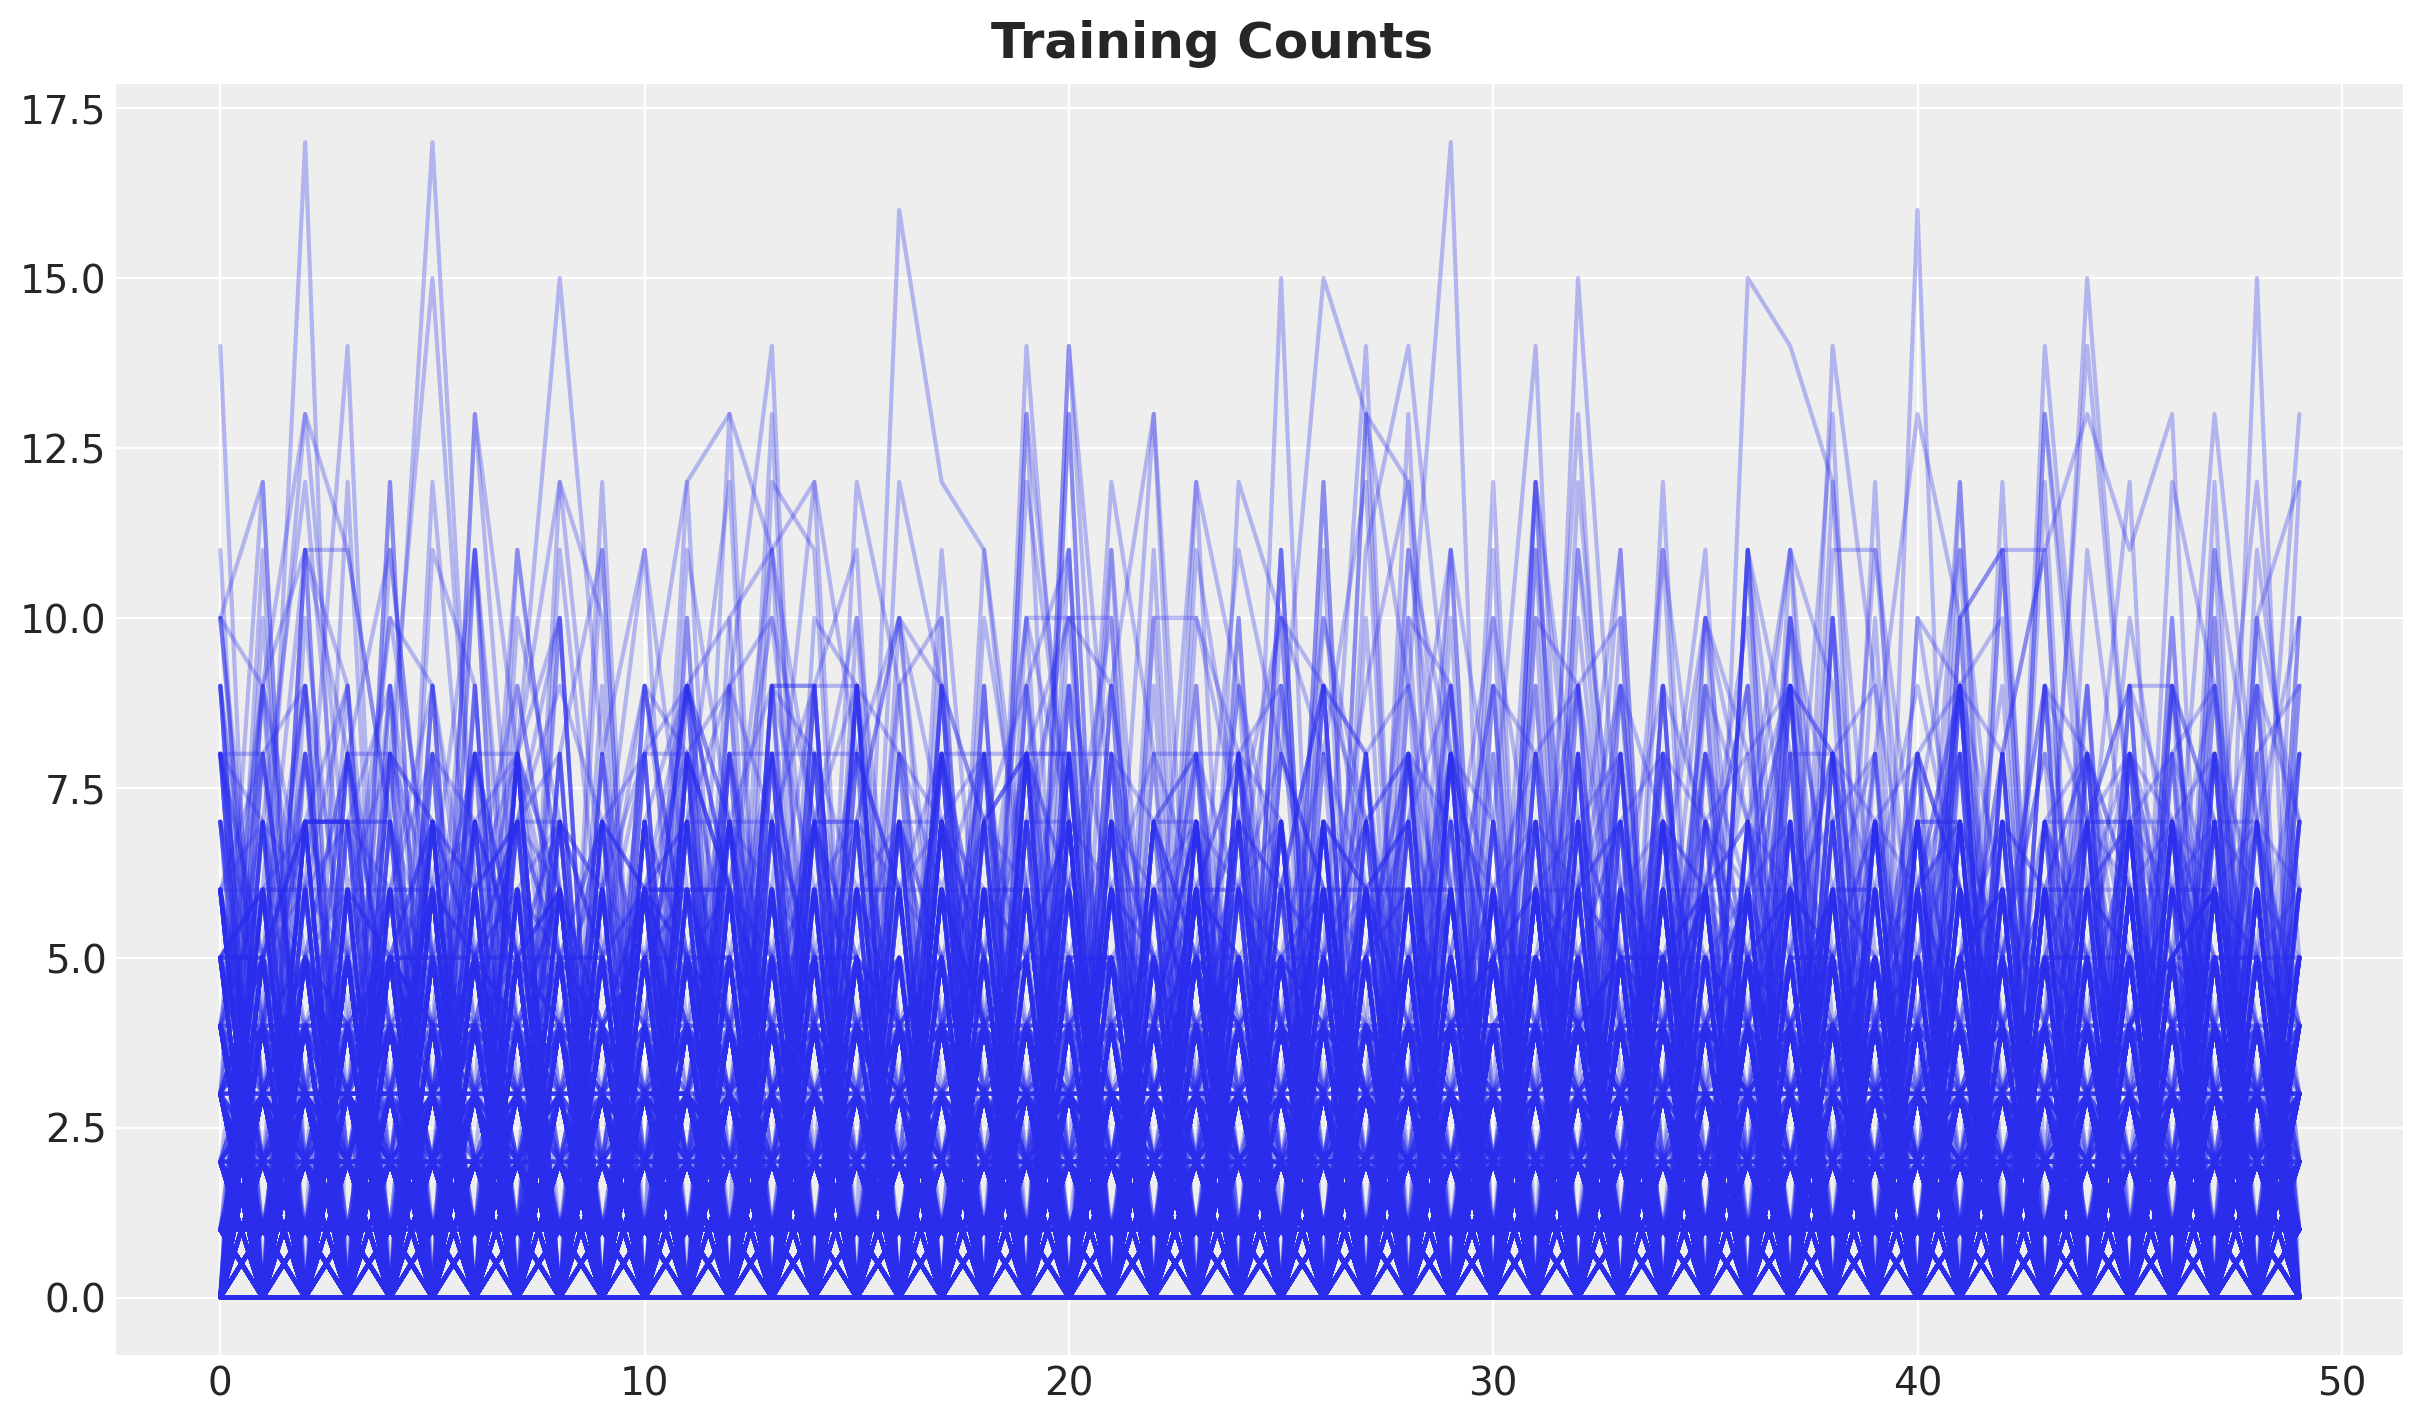

In [7]:
fig, ax = plt.subplots()
ax.plot(model_data_train.t, model_data_train.counts, c="C0", alpha=0.3)
fig.suptitle("Training Counts", fontsize=18, fontweight="bold");

## Model Specification

On its core we keep the main logic of the TSB model (see [TSB Method for Intermittent Time Series Forecasting in NumPyro](https://juanitorduz.github.io/tsb_numpyro/) for details). Denote by $y_{t}$ the input time series (let's consider a single one for simplicity). Then the TSB method is specified by the following equations:

If $y_{t} > 0$, then

$$
\begin{align*}
z_{t + 1} & = \alpha y_{t} + (1 - \alpha) z_{t} \\
p_{t + 1} & = \beta + (1 - \beta) p_{t}
\end{align*}
$$

If $y_{t} = 0$, then

$$
\begin{align*}
z_{t + 1} & = z_{t} \\
p_{t + 1} & = (1 - \beta) p_{t}
\end{align*}
$$

where $z_{t}$ is the demand (level) of the time series at time $t$, $p_{t}$ is the probability of observing a non-zero demand at time $t$, and $\alpha$ and $\beta$ are the smoothing parameters. The forecast is then given by the product.

$$
\hat{y}_{t + 1} = z_{t} p_{t}.
$$

On this experiment we consider the following extensions:

- We vectorize the model to accommodate for multiple time series.
- We add a hierarchical structure on the noise level (useful, but not necessary).
- If we denote by $a_{t}$ the availability mask, then consider the following model:

If $y_{t} = 0$, then

$$
\begin{align*}
z_{t + 1} & = z_{t} \\
p_{t + 1} & = (1 - a_{t}\beta) p_{t}
\end{align*}
$$

The idea is that if a zero comes from the lack of demand, then the probability of observing a non-zero demand should not change.

Moreover, as we know that we can not sell if the product is not available, then we add a global factor $a_{t}$ to the forecast, i.e. the expected value of the forecast is given by $\hat{y}_{t + 1} = a_{t} z_{t} p_{t}$.

Let's see how this looks in NumPyro (we keep the same priors for the smoothing parameters as in the TSB model).

In [8]:
def model(
    counts: Float32[Array, "t_max n_series"],
    available: Float32[Array, "t_max_future n_series"],
    future: int = 0,
) -> None | Float32[Array, "future n_series"]:
    """Hierarchical TSB model with availability constraints.

    Parameters
    ----------
    counts: Float32[Array, "t_max n_series"]
        Training counts.
    available: Float32[Array, "t_max_future n_series"]
        Future availability mask.
    future: int
        Number of future time steps to forecast.

    Returns
    -------
    None | Float32[Array, "future n_series"]
        Forecasted counts if we are in forecasting mode (future > 0), otherwise None.
    """
    # Extract dimensions.
    t_max, n_series = counts.shape
    # Global noise scale.
    noise_scale = numpyro.sample(
        "noise_scale", dist.LogNormal(loc=jnp.log(5), scale=0.3)
    )

    # Model parameters.
    with numpyro.plate("n_series", n_series):
        z_smoothing = numpyro.sample(
            "z_smoothing",
            dist.Beta(concentration1=10, concentration0=40),
        )

        p_smoothing = numpyro.sample(
            "p_smoothing",
            dist.Beta(concentration1=10, concentration0=40),
        )

        noise = numpyro.sample("noise", dist.HalfNormal(scale=noise_scale))

    # Transition function of the TSB model.
    def transition_fn(carry, t):
        z_prev, p_prev = carry

        z_next = jnp.where(
            t < t_max,
            jnp.where(
                counts[t] > 0,
                z_smoothing * counts[t] + (1 - z_smoothing) * z_prev,
                z_prev,
            ),
            z_prev,
        )

        p_next = jnp.where(
            t < t_max,
            jnp.where(
                counts[t] > 0,
                p_smoothing + (1 - p_smoothing) * p_prev,
                (1 - available[t] * p_smoothing) * p_prev,  # <- Availability constraint
            ),
            p_prev,
        )

        mu = z_next * p_next

        pred_raw = numpyro.sample("pred_raw", dist.Normal(loc=mu, scale=noise))

        pred = numpyro.deterministic(
            "pred", available[t] * pred_raw
        )  # <- Availability constraint

        return (z_next, p_next), pred

    # --- Run Scan ---
    _, preds = scan(
        transition_fn,
        (counts[0], 0.5 * jnp.ones_like(counts[0])),
        jnp.arange(t_max + future),
    )

    # --- Forecast ---
    if future > 0:
        return numpyro.deterministic("forecast", preds[-future:, :])
    return None

We can visualize the model structure.

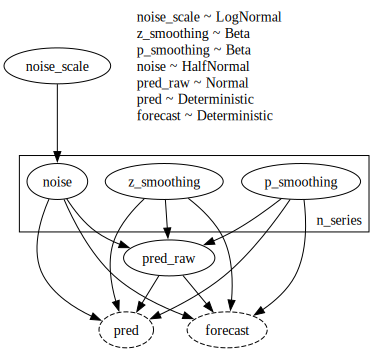

In [9]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "counts": model_data_train.counts,
        "available": model_data_train.available,
        "future": 1,
    },
    render_distributions=True,
    render_params=True,
)

## Prior Predictive Checks

Before conditioning on the data, we can visualize the prior predictive distribution.

In [10]:
prior_predictive = Predictive(
    model=model,
    num_samples=1_000,
    return_sites=["pred"],
)

rng_key, rng_subkey = random.split(key=rng_key)
prior_predictive_samples = prior_predictive(
    rng_subkey,
    counts=model_data_train.counts,
    available=model_data_train.available,
)


prior_predictive_idata = az.from_dict(
    prior_predictive={k: v[None, ...] for k, v in prior_predictive_samples.items()},
    coords={"t_max": model_data_train.t, "n_series": series_ids},
    dims={"pred": ["t_max", "n_series"]},
)

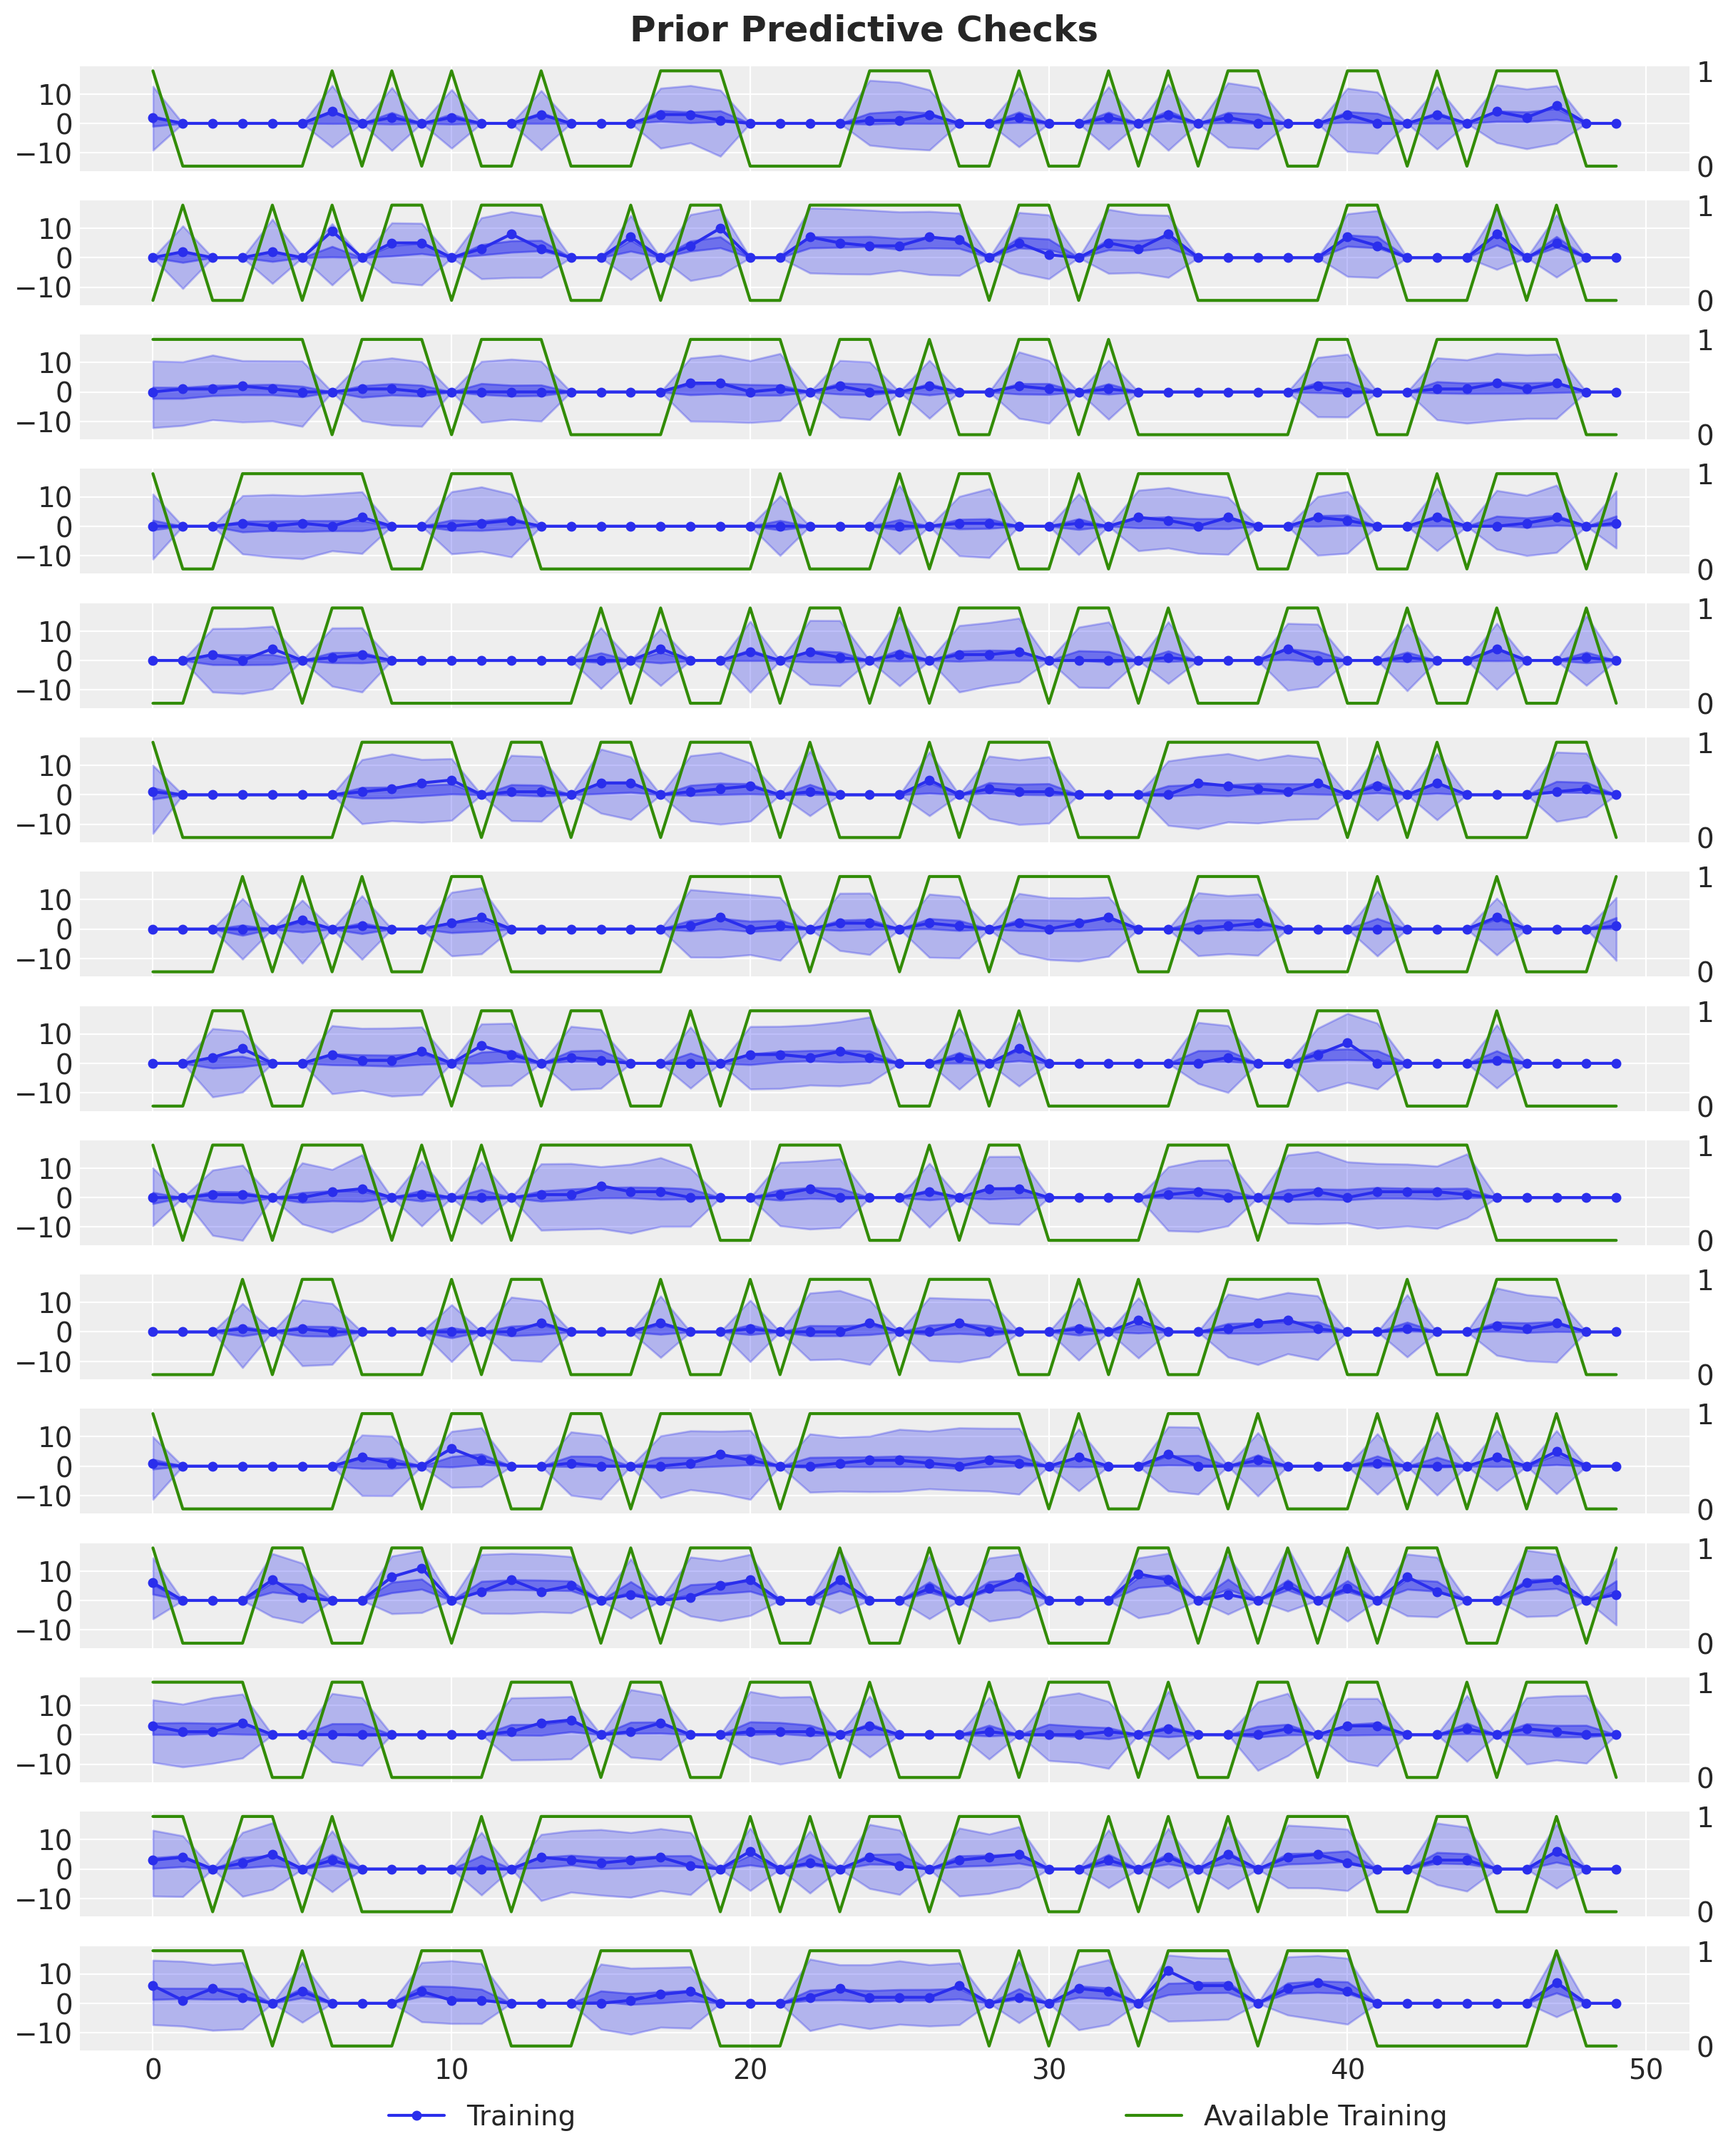

In [11]:
n_series_to_plot = 15

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    ax_i_twin = ax[i].twinx()
    az.plot_hdi(
        model_data_train.t,
        prior_predictive_idata["prior_predictive"].sel(n_series=i)["pred"],
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3},
        smooth=False,
        ax=ax[i],
    )
    az.plot_hdi(
        model_data_train.t,
        prior_predictive_idata["prior_predictive"].sel(n_series=i)["pred"],
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax[i],
    )
    ax[i].plot(
        model_data_train.t,
        model_data_train.counts[:, i],
        marker="o",
        markersize=4,
        color="C0",
        label="Training",
    )
    ax_i_twin.plot(
        model_data_train.t,
        model_data_train.available[:, i],
        color="C2",
        label="Available Training",
    )
    ax_i_twin.grid(None)

ax[i].legend(loc="lower center", bbox_to_anchor=(0.25, -1), ncol=2)
ax_i_twin.legend(loc="lower center", bbox_to_anchor=(0.75, -1), ncol=2)

fig.suptitle("Prior Predictive Checks", fontsize=18, fontweight="bold");

The prior predictive distribution looks good! Not very restrictive but within the range of the data. Moreover, note that we are enforcing the availability constraint in the model. When the availability is zero, the model is not able to predict any non-zero demand.

## SVI Inference

We now condition on the training data and perform inference with SVI.

100%|██████████| 10000/10000 [00:08<00:00, 1239.13it/s, init loss: 868750.3125, avg. loss [9501-10000]: 95884.7688]


CPU times: user 10.5 s, sys: 2.73 s, total: 13.2 s
Wall time: 10.1 s


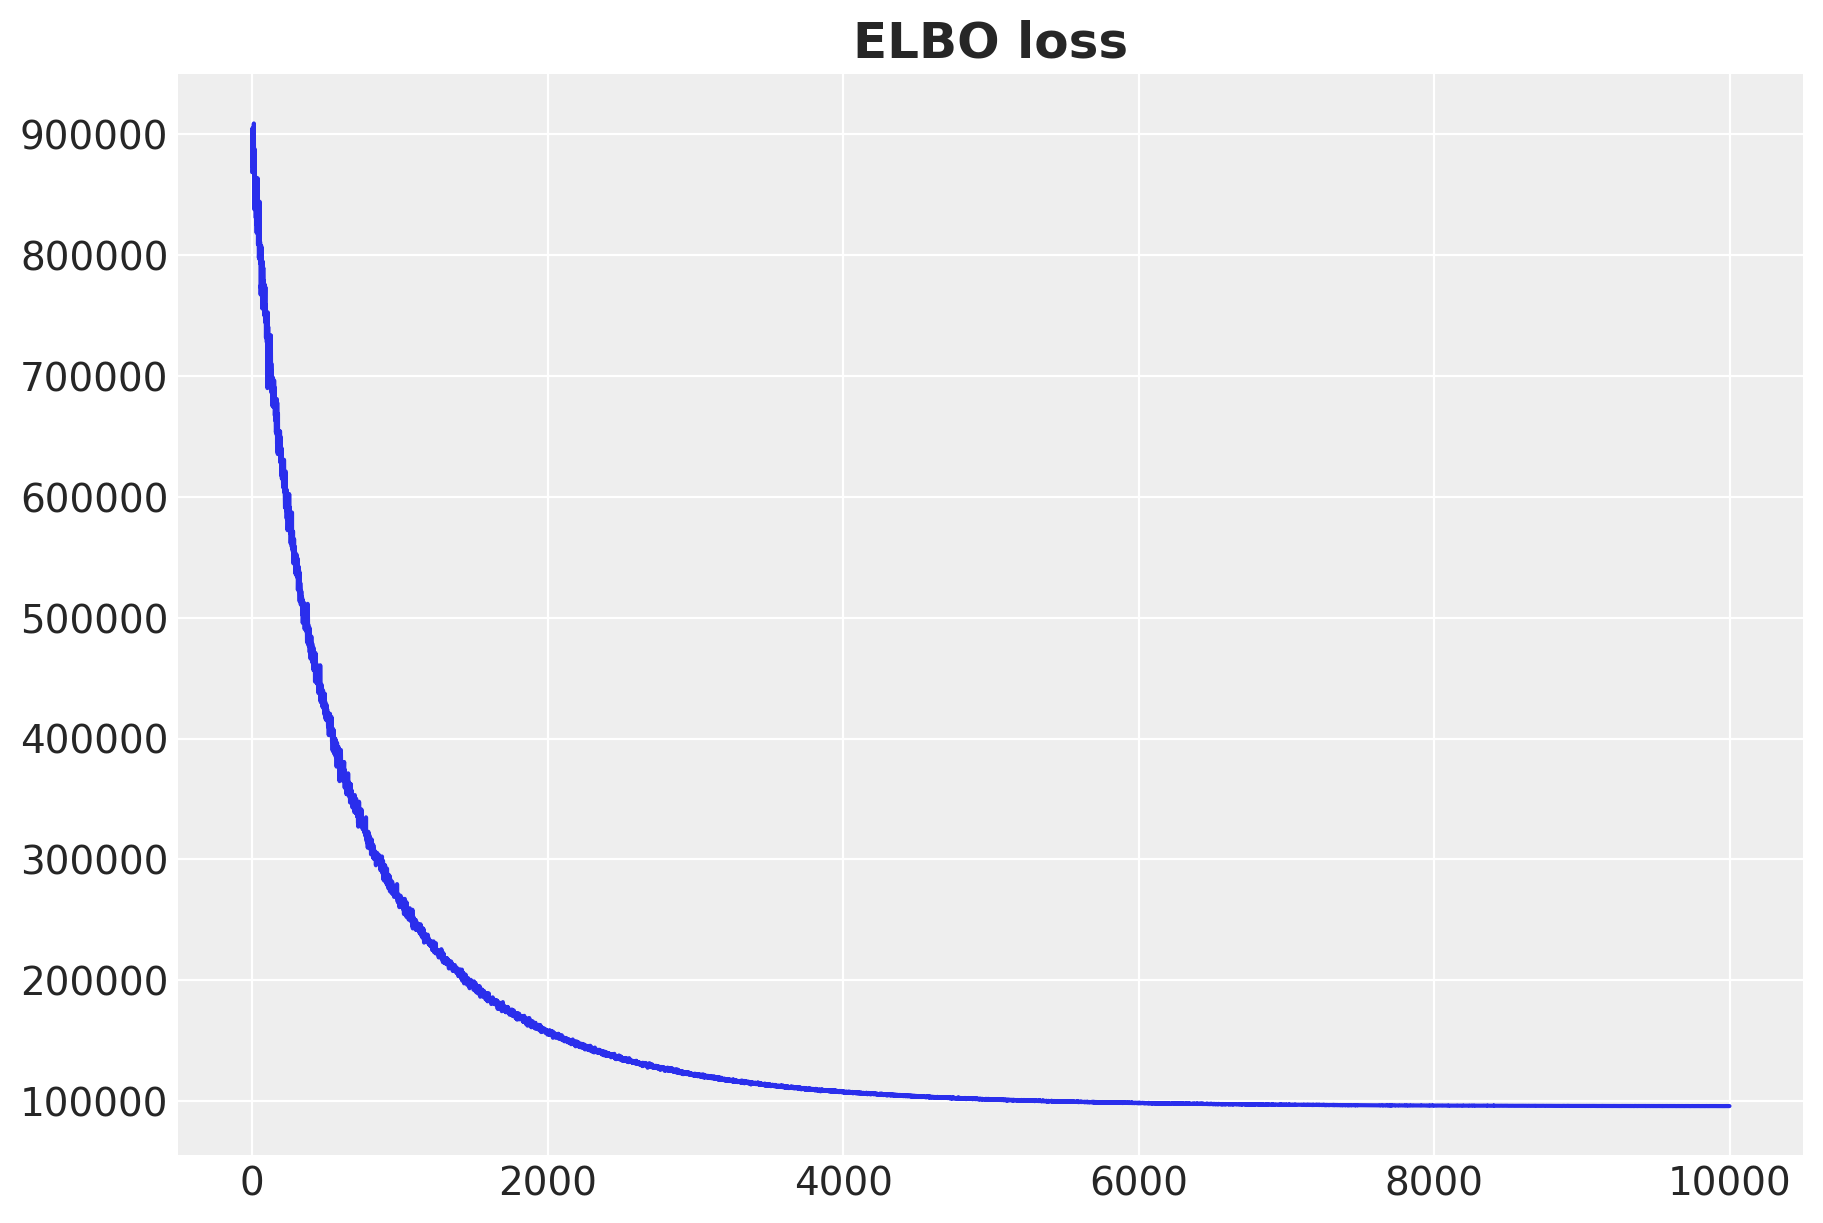

In [12]:
%%time
# We condition on the raw counts!
conditioned_model = condition(model, data={"pred_raw": model_data_train.counts})
guide = AutoNormal(conditioned_model)
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())
num_steps = 10_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    counts=model_data_train.counts,
    available=model_data_train.available,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

SVI runs very fast! The ELBO loss is decreasing as expected. We also see stability in the loss 🚀.


## Posterior Predictive Checks

After successful inference, we can now visualize the posterior predictive distribution. One important observation is that, in general, we do not have access to the future availability. Hence, here we can use the model for scenario planning. We could, for instance, set the availability to one to simulate the expected demand. We could also use past availability averages to have an estimates on the expected sales given that the availability is out of our control and we want to plan for it. In this experiment we opt for the first approach as is typically one of the most common use cases.

In [13]:
posterior_predictive = Predictive(
    model=conditioned_model,
    guide=guide,
    params=svi_result.params,
    num_samples=2_000,
    return_sites=["pred", "forecast"],
)

rng_key, rng_subkey = random.split(rng_key)
# We set the availability to one to simulate the expected demand.
future_availability = jnp.ones_like(model_data_test.available)
posterior_predictive_samples = posterior_predictive(
    rng_subkey,
    counts=model_data_train.counts,
    available=jnp.concatenate(
        [model_data_train.available, future_availability], axis=0
    ),  # <- Future availability
    future=model_data_test.t.shape[0],
)

posterior_predictive_idata = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior_predictive_samples.items()
    },
    coords={
        "t_max": model_data.t,
        "t_max_test": model_data_test.t,
        "n_series": series_ids,
    },
    dims={"pred": ["t_max", "n_series"], "forecast": ["t_max_test", "n_series"]},
)

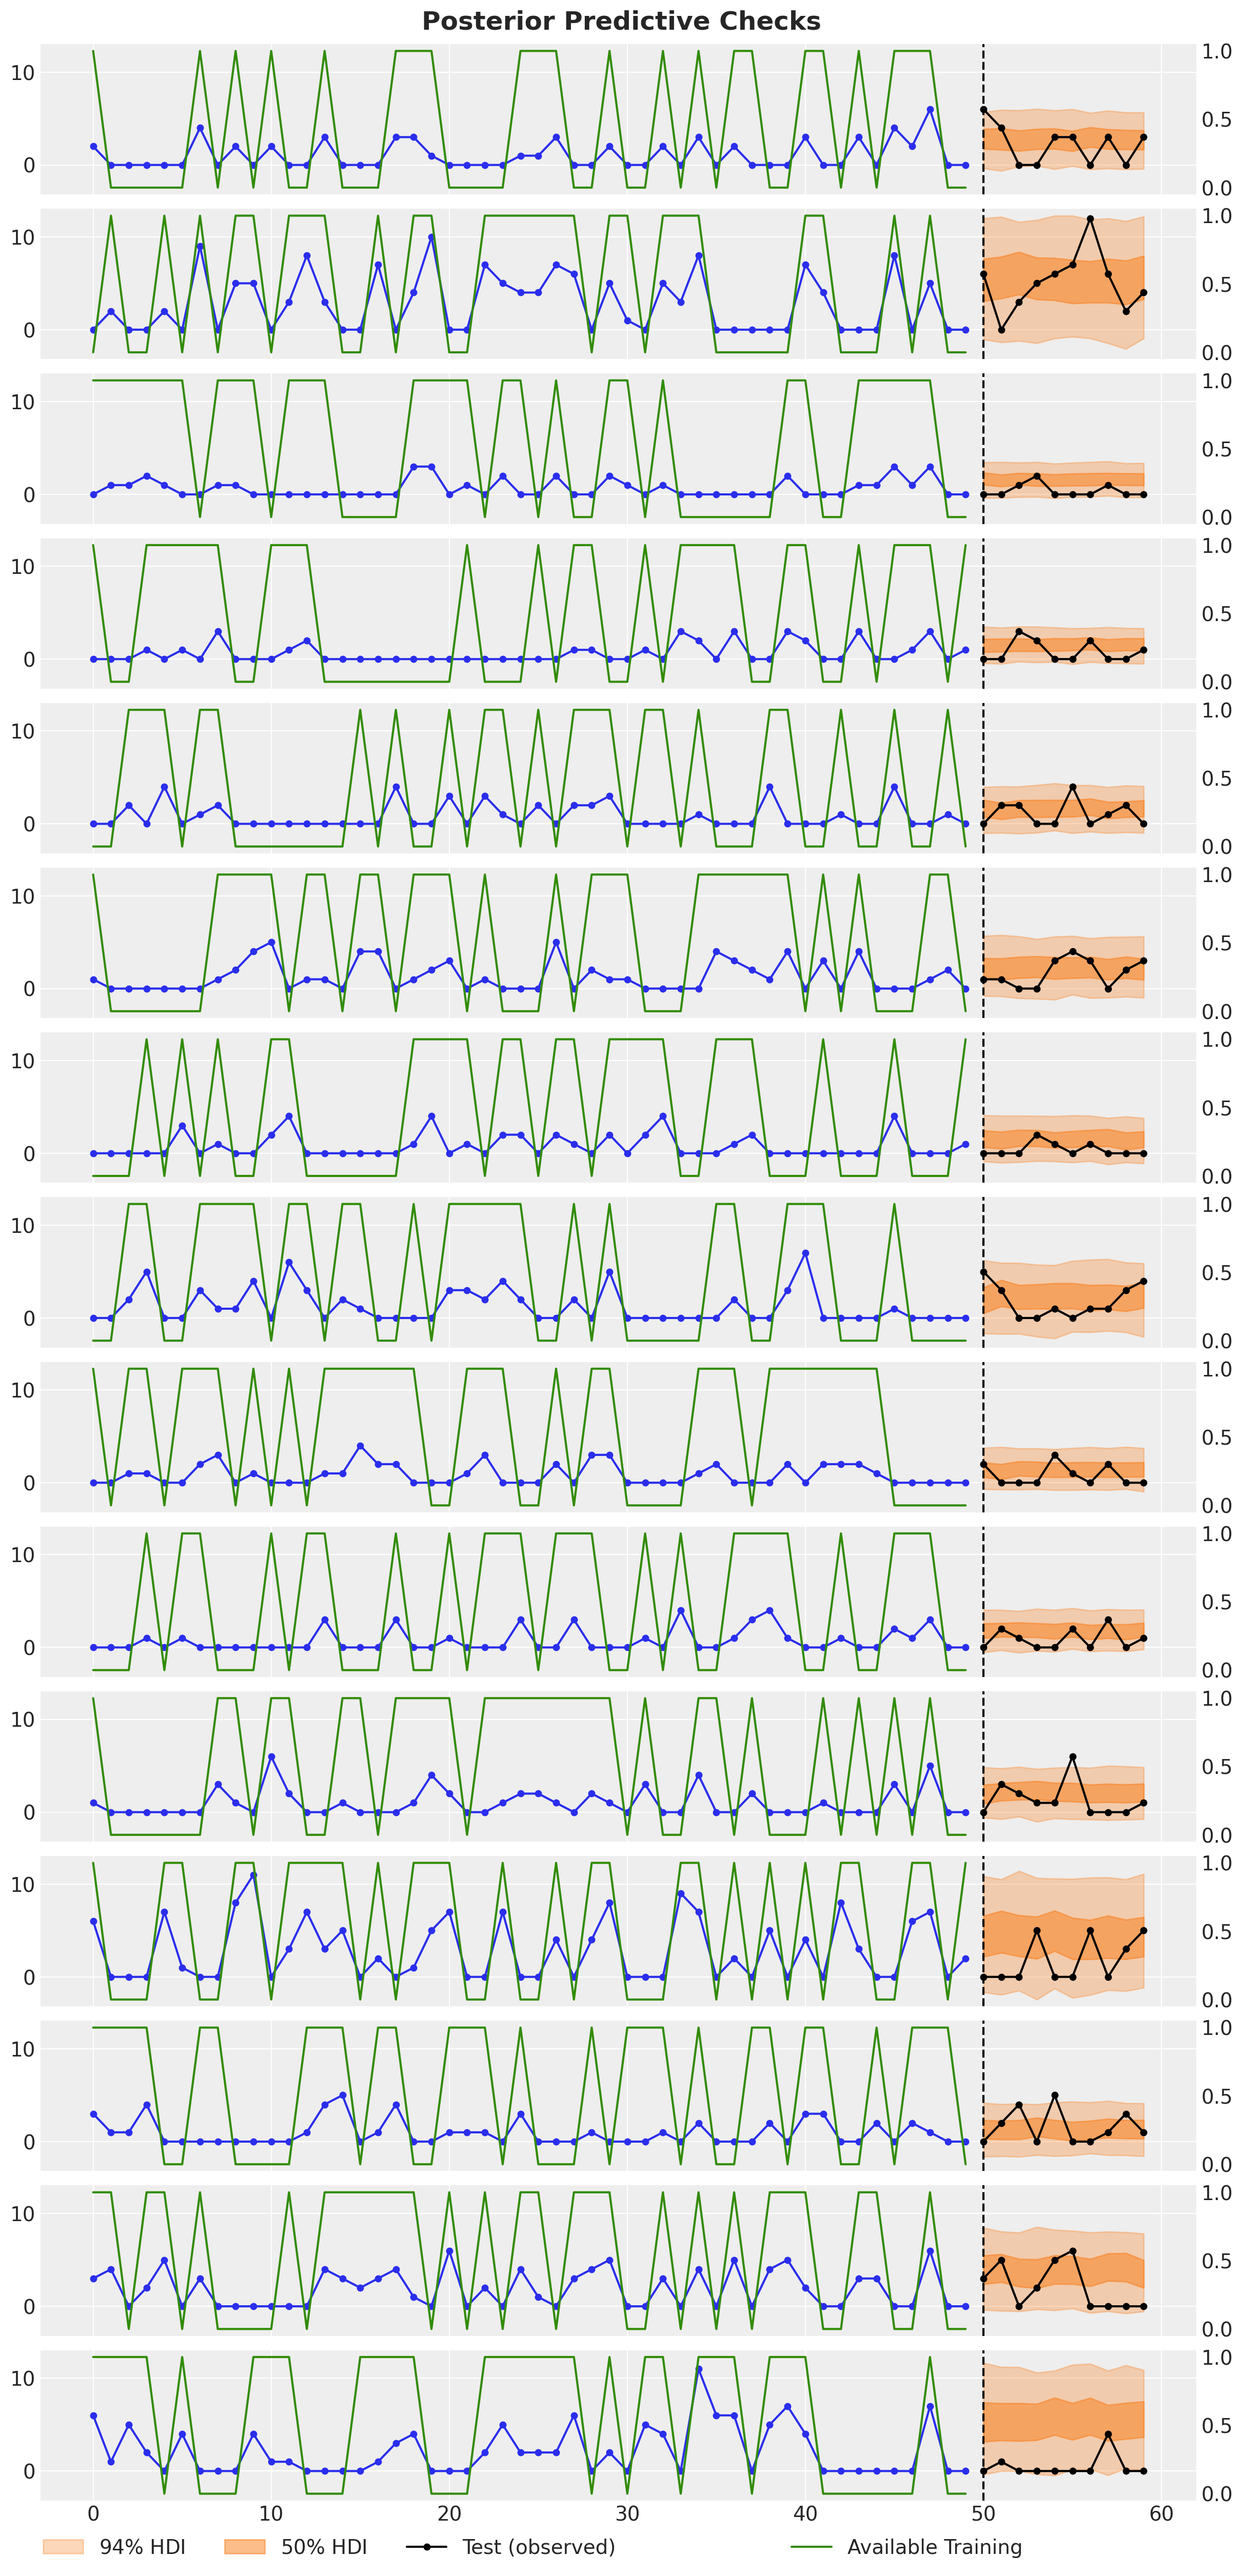

In [14]:
n_series_to_plot = 15

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in series_ids[:n_series_to_plot]:
    ax_i_twin = ax[i].twinx()
    az.plot_hdi(
        model_data_test.t,
        posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
        smooth=False,
        ax=ax[i],
    )
    az.plot_hdi(
        model_data_test.t,
        posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
        smooth=False,
        ax=ax[i],
    )
    ax[i].plot(
        model_data_train.t,
        model_data_train.counts[:, i],
        marker="o",
        markersize=4,
        color="C0",
    )
    ax[i].plot(
        model_data_test.t,
        model_data_test.counts[:, i],
        marker="o",
        markersize=4,
        color="black",
        label="Test (observed)",
    )
    ax_i_twin.plot(
        model_data_train.t,
        model_data_train.available[:, i],
        color="C2",
        label="Available Training",
    )
    ax_i_twin.grid(None)
    ax[i].axvline(x=model_data_train.t.shape[0], color="k", linestyle="--")

ax[i].legend(loc="lower center", bbox_to_anchor=(0.25, -0.5), ncol=3)
ax_i_twin.legend(loc="lower center", bbox_to_anchor=(0.75, -0.5), ncol=1)

fig.suptitle("Posterior Predictive Checks", fontsize=18, fontweight="bold");

All the forecasts look very reasonable and they mostly cover the observed counts (which have an unknown availability at prediction time).

To understand the impact of the availability constraint, let's plot the forecast of a single series.

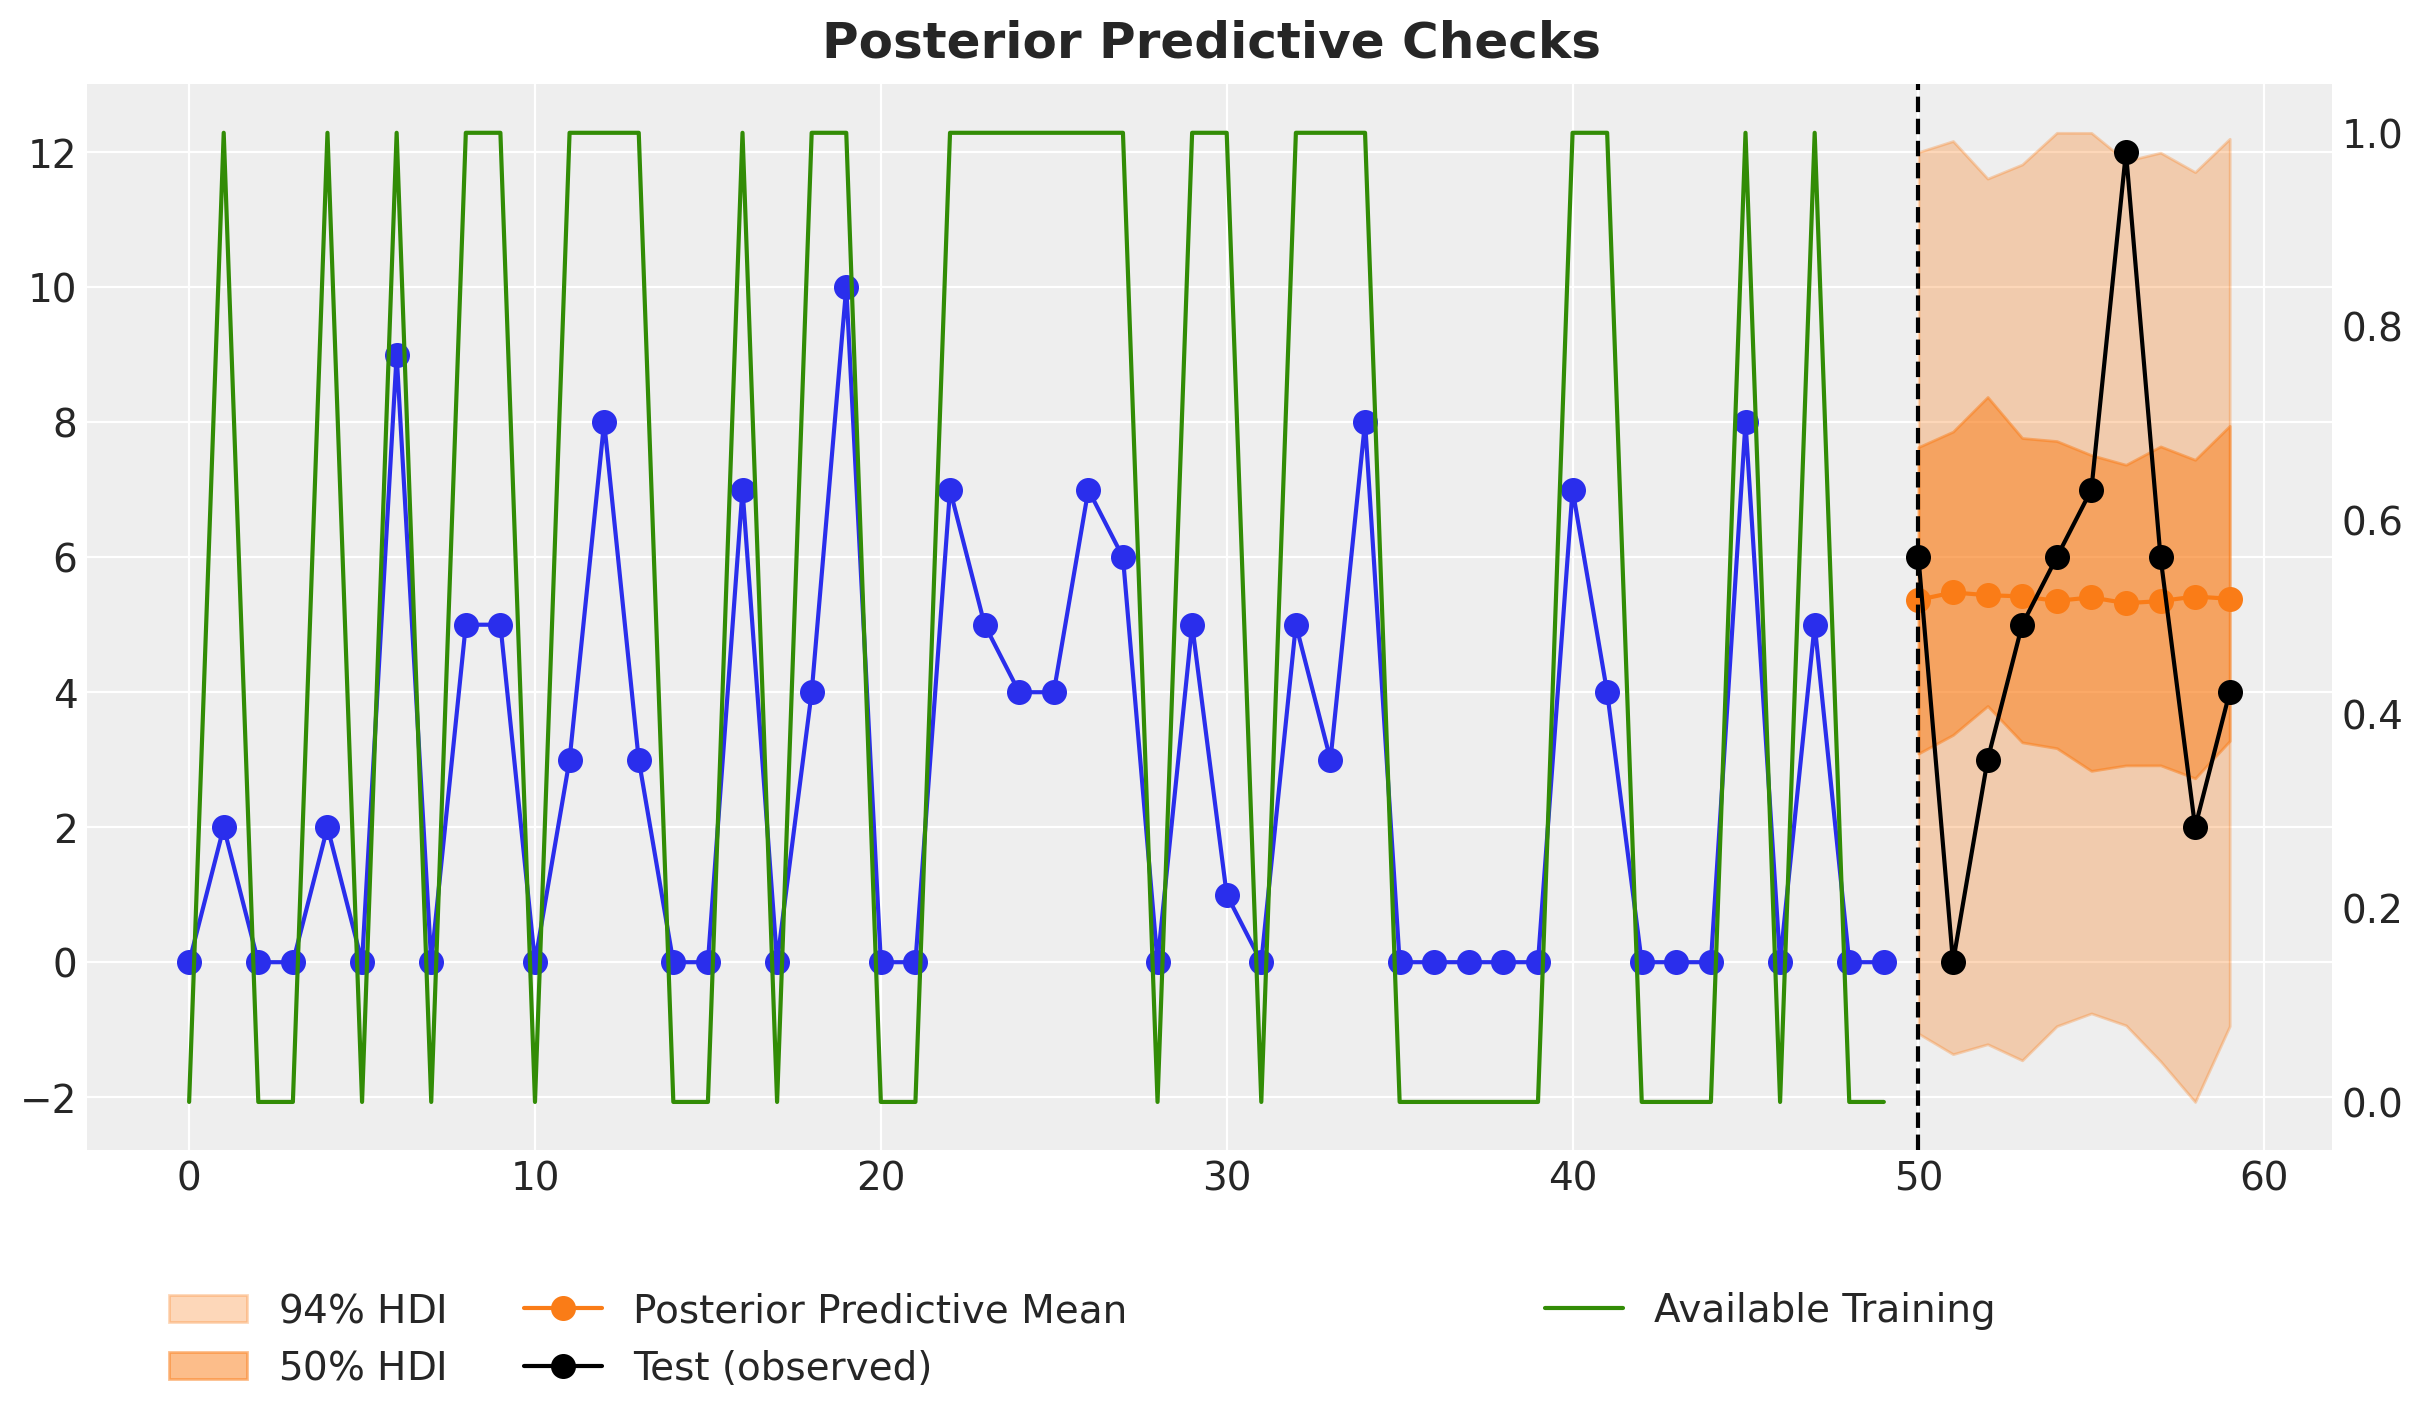

In [15]:
fig, ax = plt.subplots()
i = 1
ax_twin = ax.twinx()
az.plot_hdi(
    model_data_test.t,
    posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    model_data_test.t,
    posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.plot(
    model_data_test.t,
    posterior_predictive_idata["posterior_predictive"]
    .sel(n_series=i)["forecast"]
    .mean(dim=("chain", "draw")),
    marker="o",
    markersize=8,
    color="C1",
    label="Posterior Predictive Mean",
)
ax.plot(
    model_data_train.t,
    model_data_train.counts[:, i],
    marker="o",
    markersize=8,
    color="C0",
)
ax.plot(
    model_data_test.t,
    model_data_test.counts[:, i],
    marker="o",
    markersize=8,
    color="black",
    label="Test (observed)",
)
ax_twin.plot(
    model_data_train.t,
    model_data_train.available[:, i],
    color="C2",
    label="Available Training",
)
ax_twin.grid(None)
ax.axvline(x=model_data_train.t.shape[0], color="k", linestyle="--")
ax.legend(bbox_to_anchor=(0.25, -0.1), loc="upper center", ncol=2)
ax_twin.legend(bbox_to_anchor=(0.75, -0.1), loc="upper center", ncol=1)
fig.suptitle("Posterior Predictive Checks", fontsize=18, fontweight="bold");

Despite the fact the last two data points of tht training data are zeros, the model does not simply predict zeros for the next time steps, which is usual for intermittent time series models. The reason is that the model is aware of the fact that these last two zeros are due to the lack of availability and not actual demand. Hence, when we set the availability to one for the future, the forecast is not zero. This is exactly what we want!


## Time Slice Cross-Validation

Finally, to understand how the forecast changes as we collect more data, we perform a one-time-ahead time slice cross-validation. We simply wrap the whole fit and forecast logic into a function.

In [16]:
def time_slice_cross_validation(
    rng_key: UInt32[Array, "2"],
    counts: Float32[Array, "t_max n_series"],
    available: Float32[Array, "t_max n_series"],
    n_splits: int = 5,
) -> xr.Dataset:
    forecast_list = []
    for i in tqdm(range(n_splits)):
        # Prepare data
        counts_train = counts[: -(n_splits - i), :]
        available_train = available[: -(n_splits - i), :]

        # Inference
        conditioned_model = condition(model, data={"pred_raw": counts_train})
        guide = AutoNormal(conditioned_model)
        optimizer = numpyro.optim.Adam(step_size=0.001)
        svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())
        num_steps = 10_000

        rng_key, rng_subkey = random.split(key=rng_key)
        svi_result = svi.run(
            rng_subkey,
            num_steps,
            counts=counts_train,
            available=available_train,
        )

        # Forecast
        rng_key, rng_subkey = random.split(rng_key)
        posterior_predictive = Predictive(
            model=conditioned_model,
            guide=guide,
            params=svi_result.params,
            num_samples=2_000,
            return_sites=["forecast"],
        )

        rng_key, rng_subkey = random.split(rng_key)
        future_availability = jnp.ones_like(model_data_train.available[:1, :])
        posterior_predictive_samples = posterior_predictive(
            rng_subkey,
            counts=counts_train,
            available=jnp.concatenate([available_train, future_availability], axis=0),
            future=1,
        )

        posterior_predictive_idata = az.from_dict(
            posterior_predictive={
                k: v[None, ...] for k, v in posterior_predictive_samples.items()
            },
            coords={"t_max": [counts_train.shape[0]], "n_series": series_ids},
            dims={"forecast": ["t_max", "n_series"]},
        )

        forecast_list.append(posterior_predictive_idata)

    # Concatenate forecasts
    return xr.concat(
        [x["posterior_predictive"] for x in forecast_list],
        dim=("t_max"),
    )

In [17]:
%%time

rng_key, rng_subkey = random.split(rng_key)
forecast_cv = time_slice_cross_validation(
    rng_subkey,
    counts=model_data.counts,
    available=model_data.available,
    n_splits=model_data_test.t.shape[0],
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:08<00:00, 1152.79it/s, init loss: 1077321.2500, avg. loss [9501-10000]: 113518.3119]


CPU times: user 1min 42s, sys: 26.4 s, total: 2min 8s
Wall time: 1min 37s


We can inspect the results.

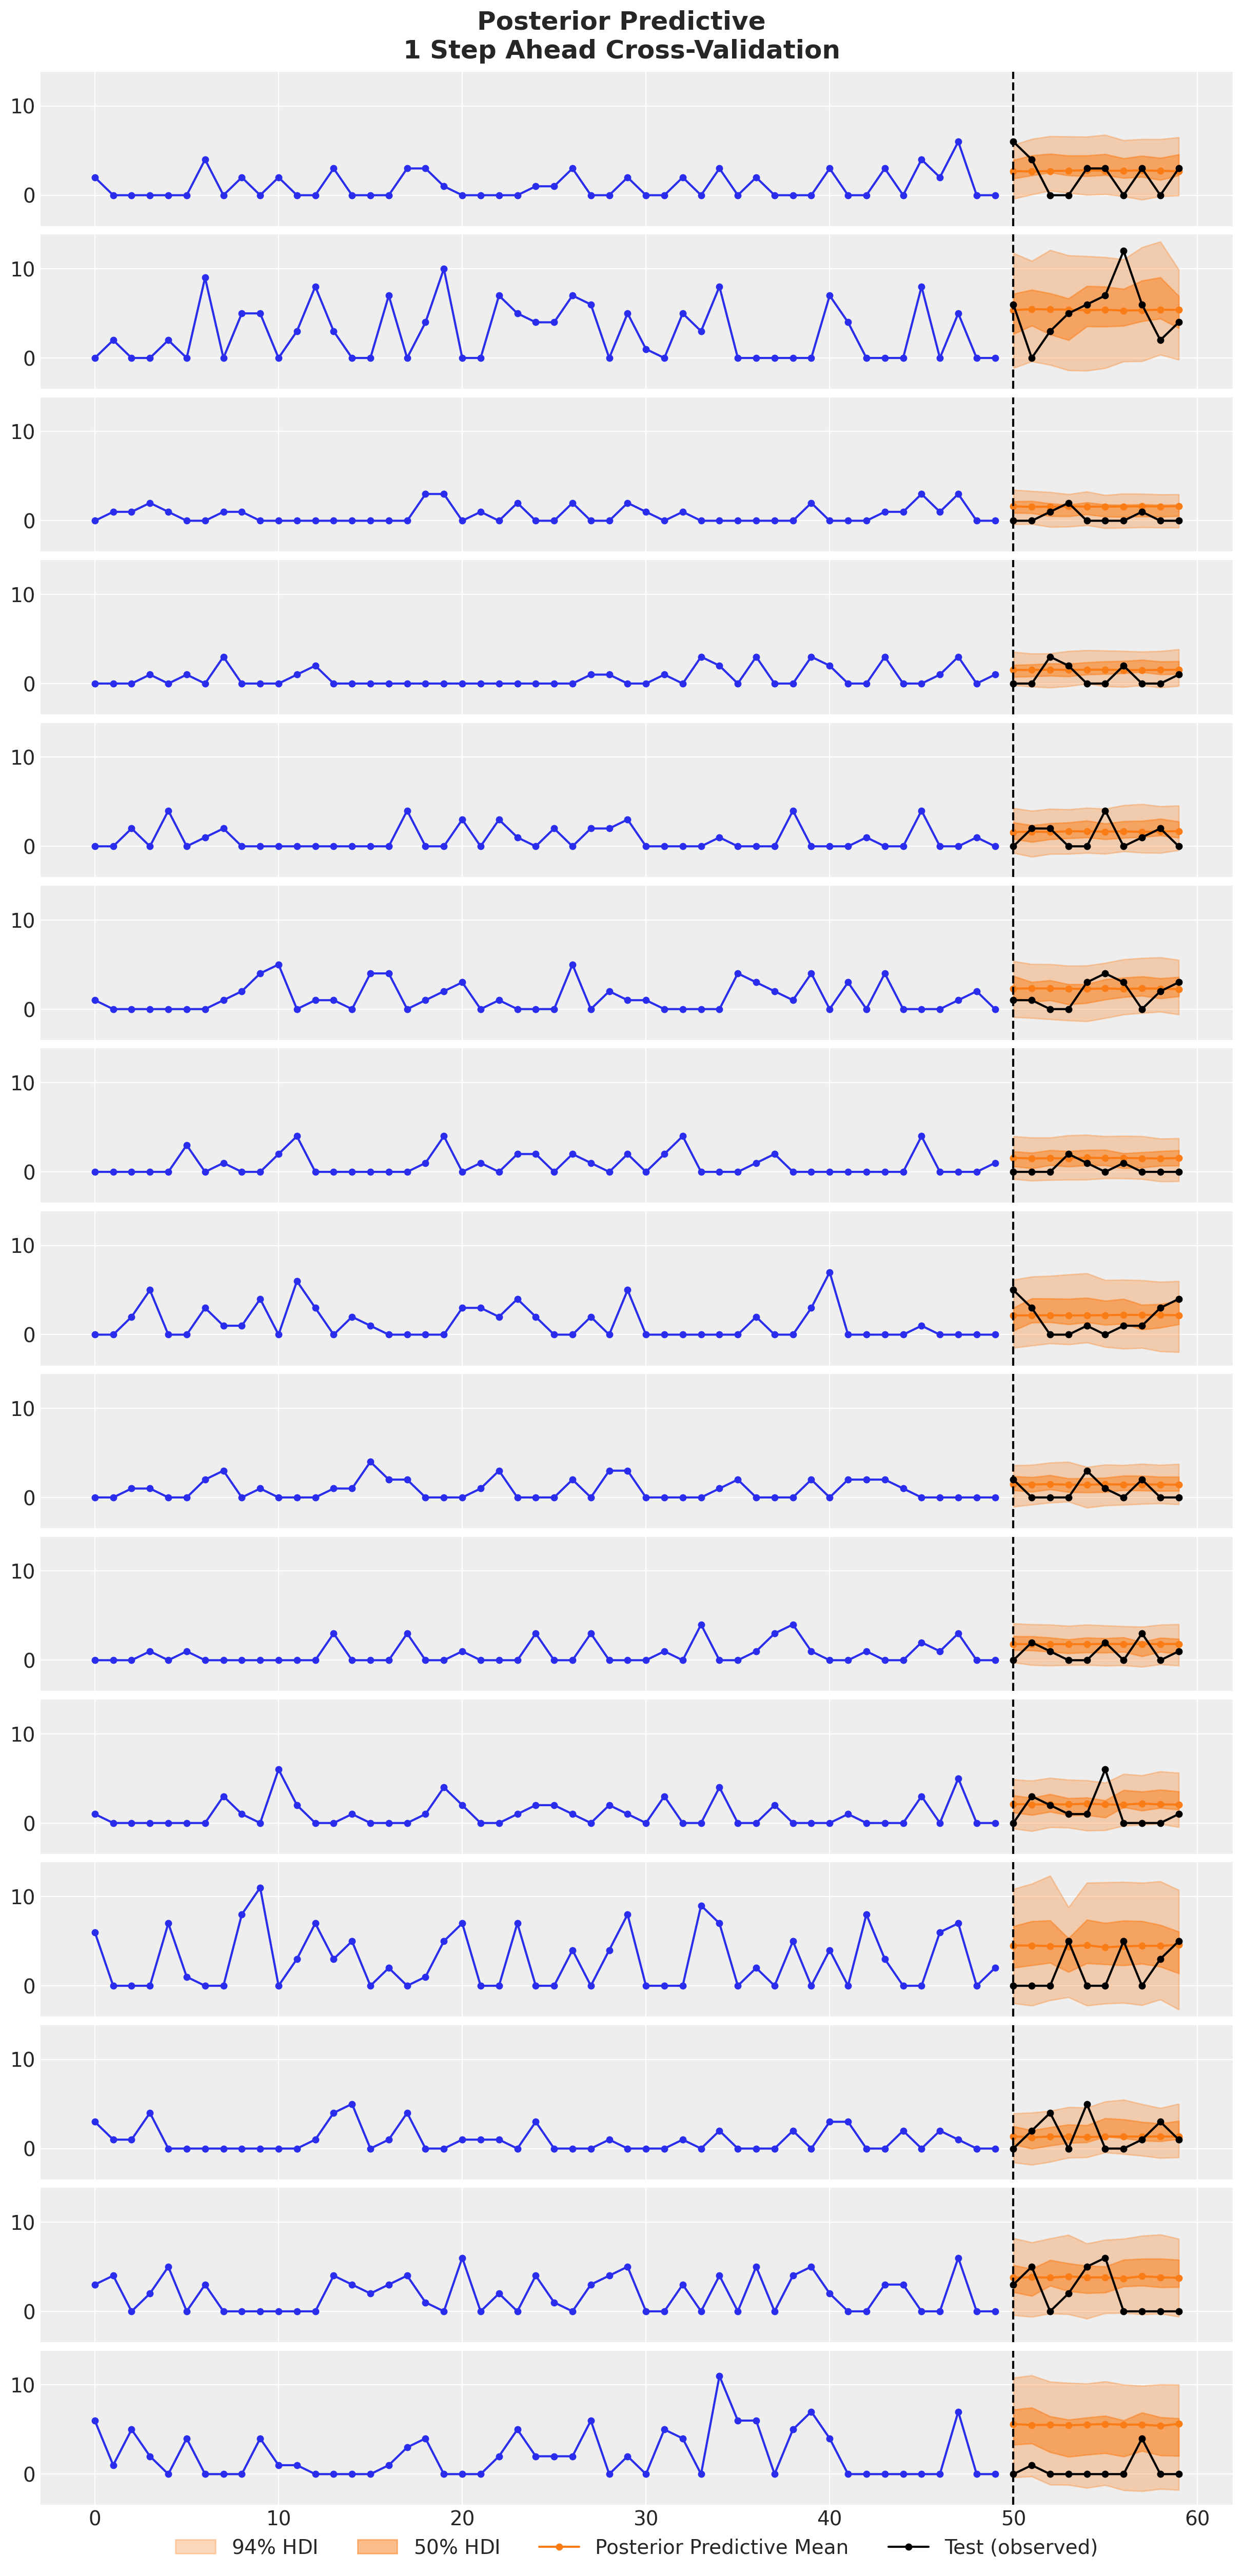

In [18]:
n_series_to_plot = 15

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in series_ids[:n_series_to_plot]:
    az.plot_hdi(
        model_data_test.t,
        forecast_cv.sel(n_series=i)["forecast"],
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
        smooth=False,
        ax=ax[i],
    )
    az.plot_hdi(
        model_data_test.t,
        forecast_cv.sel(n_series=i)["forecast"],
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
        smooth=False,
        ax=ax[i],
    )
    ax[i].plot(
        model_data_test.t,
        posterior_predictive_idata["posterior_predictive"]
        .sel(n_series=i)["forecast"]
        .mean(dim=("chain", "draw")),
        marker="o",
        markersize=4,
        color="C1",
        label="Posterior Predictive Mean",
    )
    ax[i].plot(
        model_data_train.t,
        model_data_train.counts[:, i],
        marker="o",
        markersize=4,
        color="C0",
    )
    ax[i].plot(
        model_data_test.t,
        model_data_test.counts[:, i],
        marker="o",
        markersize=4,
        color="black",
        label="Test (observed)",
    )
    ax[i].axvline(x=model_data_train.t.shape[0], color="k", linestyle="--")

ax[i].legend(bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=4)

fig.suptitle(
    "Posterior Predictive\n1 Step Ahead Cross-Validation",
    fontsize=18,
    fontweight="bold",
);

We clearly see that the the TSB model is able to adapt the non-zero probabilities parameter for each new data point. The drop in this probability due to a zero observation not as strong as if we would only used the original TSB model.